In [1]:
import gymnasium as gym
import numpy as np
import pandas
import seaborn as sns
import torch
from einops import einsum, pack, rearrange, repeat
from matplotlib import pyplot as plt
from torch import nn

from legato.nets import Perceptron, TransitionModel

In [2]:
np_rng = np.random.default_rng(0)

In [3]:
# Load data from data.npz
data = np.load("data.npz")
indices = np.load("trained_net_params/indices.npz")
train_indices, test_indices = indices["train_indices"], indices["test_indices"]

observations_train = data["observations"][train_indices]
actions_train = data["actions"][train_indices]

observations_test = torch.tensor(data["observations"][test_indices], dtype=torch.float32, device="cuda")
actions_test = torch.tensor(data["actions"][test_indices], dtype=torch.float32, device="cuda")

In [4]:
# Load models
state_encoder = torch.load("trained_net_params/state_encoder.pt")
action_encoder = torch.load("trained_net_params/action_encoder.pt")
transition_model = torch.load("trained_net_params/transition_model.pt")
state_decoder = torch.load("trained_net_params/state_decoder.pt")
action_decoder = torch.load("trained_net_params/action_decoder.pt")

In [5]:
flat_states = rearrange(observations_test, "... f -> (...) f")[:2048]
flat_actions = rearrange(actions_test, "... f -> (...) f")[:2048]

In [6]:
# Get stdev of encoded states and actions across each element
with torch.no_grad():
    encoded_states = state_encoder(flat_states)
    state_std = torch.std(encoded_states, dim=0)

    encoded_actions = action_encoder(flat_actions, flat_states)

    recovered_states = state_decoder(encoded_states)
    recovered_actions = action_decoder(encoded_actions, encoded_states)

    action_std = torch.std(encoded_actions, dim=0)

In [7]:
encoded_states

tensor([[ 0.1246, -0.0285, -1.2650, -0.5100],
        [ 0.1228, -0.0262, -1.2601, -0.5124],
        [ 0.1171, -0.0291, -1.2487, -0.5172],
        ...,
        [-0.0066, -0.0738, -1.3422, -0.1103],
        [ 0.0050, -0.0618, -1.3553, -0.1054],
        [-0.0027, -0.0576, -1.3419, -0.1103]], device='cuda:0')

In [8]:
encoded_actions

tensor([[-0.7795, -0.1192],
        [-0.8394, -0.1013],
        [-0.8682, -0.1021],
        ...,
        [-0.1990,  0.7770],
        [-0.0019,  0.8558],
        [-0.2688,  0.6908]], device='cuda:0')

In [9]:
print(f"State std: {state_std.cpu().numpy()}\nAction std: {action_std.cpu().numpy()}")

State std: [0.09170478 0.04889403 0.113553   0.17032346]
Action std: [0.34954387 0.445637  ]


In [10]:
transition_batch_size = 32
# Test forward model
traj_inds = torch.randint(
    0, observations_test.shape[0], (transition_batch_size,), device="cuda"
)
test_start_inds = torch.randint(
    0, int(observations_test.shape[-2] // 1.1), (transition_batch_size,), device="cuda"
)

test_states = observations_test[traj_inds]
test_actions = actions_test[traj_inds]

start_states = observations_test[traj_inds, test_start_inds]

In [11]:
start_states.shape

torch.Size([32, 4])

In [12]:
latent_start_states = state_encoder(start_states)

latent_traj_actions = action_encoder(test_actions, test_states)

latent_pred_fut_states = transition_model(
    latent_start_states, latent_traj_actions, start_indices=test_start_inds
)

In [13]:
latent_fut_states = state_encoder(test_states)

traj_ind = traj_inds[0]
start_ind = test_start_inds[0]

latent_fut_states_select = latent_fut_states[0, start_ind:]
latent_pred_fut_states_select = latent_pred_fut_states[0, start_ind:]

In [14]:
torch.stack([latent_fut_states_select, latent_pred_fut_states_select], dim=-1)

tensor([[[ 0.0976,  0.1142],
         [-0.0849, -0.0217],
         [-1.4196, -1.3258],
         [-0.3434, -0.3540]],

        [[ 0.0921,  0.1177],
         [-0.0806, -0.0238],
         [-1.4074, -1.3594],
         [-0.3476, -0.3499]],

        [[ 0.0993,  0.0780],
         [-0.0752, -0.0695],
         [-1.4278, -1.3657],
         [-0.3427, -0.3577]],

        ...,

        [[-0.1773, -0.0443],
         [-0.0958, -0.0600],
         [-1.4285, -1.5188],
         [-0.3660, -0.2171]],

        [[-0.1790, -0.0525],
         [-0.0885, -0.0566],
         [-1.4239, -1.5318],
         [-0.3684, -0.2276]],

        [[-0.1719, -0.0522],
         [-0.0858, -0.0515],
         [-1.4349, -1.5427],
         [-0.3646, -0.2307]]], device='cuda:0', grad_fn=<StackBackward0>)

In [15]:
# Measure error per time into the future

time_into_future = torch.arange(
    latent_fut_states.shape[-2], device="cuda"
)[None] - test_start_inds[..., None]

In [16]:
mae_errors = torch.mean(
    torch.abs(latent_fut_states - latent_pred_fut_states), dim=-1
)

In [17]:
mae_errors_flat = rearrange(mae_errors, "... -> (...)").detach().cpu().numpy()
time_into_future_flat = (
    rearrange(time_into_future, "... -> (...)").detach().cpu().numpy()
)

df = pandas.DataFrame.from_dict(
    {"mae_error": mae_errors_flat, "time_into_future": time_into_future_flat},
)
df = df[df["time_into_future"] >= 0]

(0.0, 1024.0)

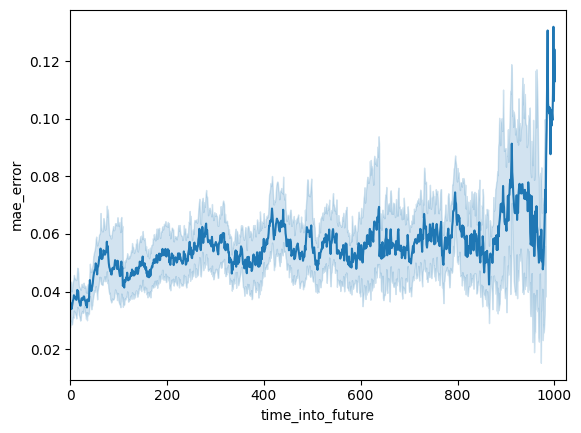

In [18]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="time_into_future", y="mae_error", ax=ax)
ax.set_xlim(0, 1024)